In [1]:
# !pip install matplotlib seaborn scikit-learn
# !pip install torch==1.13.0 torchvision==0.14.0 torchaudio==0.13.0
# !pip install torch-geometric
# !pip install torch-scatter torch-sparse torch-cluster
# !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.0+cpu.html
# !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.0+cpu.html
# !pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.13.0+cpu.html

In [2]:
!python --version

Python 3.9.15


## GCN Model Class

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

## Training Function

In [4]:
def train_model(model, data, optimizer, criterion, epochs=200, device='cpu', verbose=True):
    model = model.to(device)
    data = data.to(device)
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if verbose and epoch % 10 == 0:
            train_acc, val_acc, test_acc = evaluate_model(model, data, device)
            print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")


## Evaluation Function

In [5]:
def evaluate_model(model, data, device='cpu'):
    model = model.to(device)
    data = data.to(device)
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        accs = []
        for mask in [data.train_mask, data.val_mask, data.test_mask]:
            correct = pred[mask] == data.y[mask]
            accs.append(int(correct.sum()) / int(mask.sum()))
    return accs


## Visualization Function

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_embeddings(model, data, device='cpu'):
    """Visualize node embeddings using t-SNE."""
    model = model.to(device)
    data = data.to(device)
    model.eval()
    with torch.no_grad():
        embeddings = model(data.x, data.edge_index).cpu()
    
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
        hue=data.y.cpu().numpy(),
        palette="deep", s=50, alpha=0.8
    )
    plt.title("t-SNE Visualization of Node Embeddings")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(title="Class", loc='best')
    plt.show()


## Hyperparameter Tuning Function

In [7]:
from itertools import product

def hyperparameter_tuning(num_classes, data, param_grid, epochs=50, device='cpu'):
    """Perform grid search for hyperparameter tuning."""
    best_val_acc = 0
    best_params = None

    for lr, hidden_dim, dropout in product(param_grid['lr'], param_grid['hidden_dim'], param_grid['dropout']):
        print(f"Testing Hyperparameters: LR={lr}, Hidden={hidden_dim}, Dropout={dropout}")
        
        # Initialize Model, Optimizer, and Loss Function
        model = GCNModel(
            input_dim=data.num_node_features,
            hidden_dim=hidden_dim,
            output_dim=num_classes,
            dropout=dropout
        )
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
        criterion = torch.nn.CrossEntropyLoss()

        # Train Model
        train_model(model, data, optimizer, criterion, epochs=epochs, device=device, verbose=False)

        # Evaluate Performance
        _, val_acc, _ = evaluate_model(model, data, device)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = {'lr': lr, 'hidden_dim': hidden_dim, 'dropout': dropout}
            print(f"New Best Params: {best_params}, Val Acc: {val_acc:.4f}")

    print(f"Best Hyperparameters: {best_params}, Best Val Acc: {best_val_acc:.4f}")
    return best_params


## Load Dataset

In [8]:
from torch_geometric.datasets import Planetoid

dataset_name = 'Cora'
dataset = Planetoid(root='/tmp', name=dataset_name)
data = dataset[0]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cpu')

In [10]:
num_classes = dataset.num_classes
num_classes

7

## Basic Information

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

In [12]:
print("Dataset Name:", dataset_name)
print("Number of Graphs:", len(dataset))  # Should be 1 for Planetoid datasets
print("Number of Nodes:", data.num_nodes)
print("Number of Edges:", data.num_edges)
print("Number of Features per Node:", dataset.num_node_features)
print("Number of Classes:", dataset.num_classes)
print("Is Directed:", data.is_directed())
print("Edge Index Shape:", data.edge_index.shape)
print("Node Feature Shape:", data.x.shape)
print("Label Shape:", data.y.shape)

# Graph Density
density = 2 * data.num_edges / (data.num_nodes * (data.num_nodes - 1))
print(f"Graph Density: {density:.4f}")

# Node Feature Statistics
node_features = data.x.numpy()
print("Node Feature Summary:")
print(f"Min: {node_features.min():.4f}, Max: {node_features.max():.4f}, Mean: {node_features.mean():.4f}")

# Check for Missing Values
missing_features = torch.isnan(data.x).sum()
print(f"Missing Features: {missing_features}")

# Check Class Distribution
labels = data.y.numpy()
unique_labels, label_counts = torch.unique(data.y, return_counts=True)
print("Class Distribution:")
for label, count in zip(unique_labels, label_counts):
    print(f"Class {label}: {count}")

Dataset Name: Cora
Number of Graphs: 1
Number of Nodes: 2708
Number of Edges: 10556
Number of Features per Node: 1433
Number of Classes: 7
Is Directed: False
Edge Index Shape: torch.Size([2, 10556])
Node Feature Shape: torch.Size([2708, 1433])
Label Shape: torch.Size([2708])
Graph Density: 0.0029
Node Feature Summary:
Min: 0.0000, Max: 1.0000, Mean: 0.0127
Missing Features: 0
Class Distribution:
Class 0: 351
Class 1: 217
Class 2: 418
Class 3: 818
Class 4: 426
Class 5: 298
Class 6: 180


## Visualize the Graph (small subset for clarity)

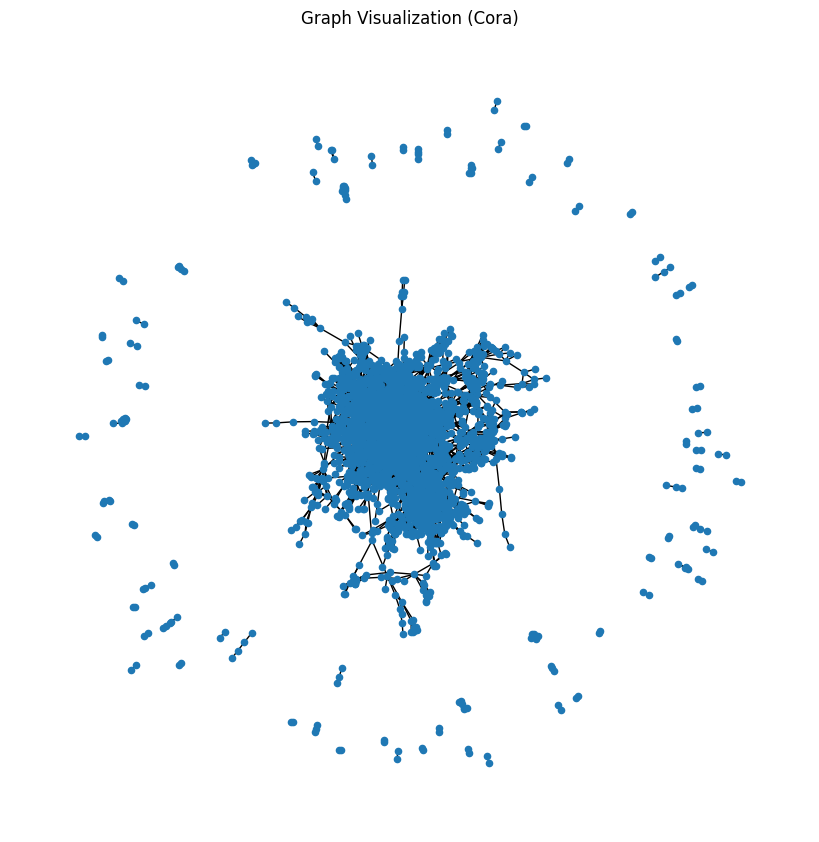

In [13]:
subgraph = to_networkx(data, to_undirected=True)
plt.figure(figsize=(8, 8))
nx.draw(subgraph, node_size=20, with_labels=False)
plt.title("Graph Visualization (Cora)")
plt.show()

## Plot Class Distribution

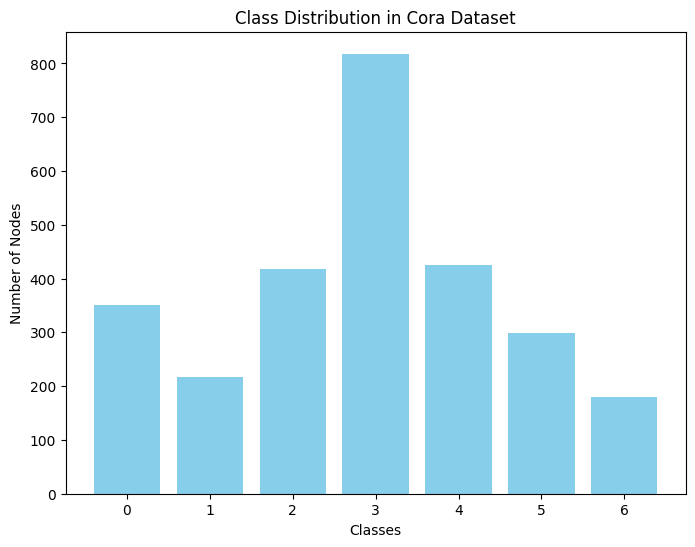

In [14]:
plt.figure(figsize=(8, 6))
plt.bar(unique_labels.numpy(), label_counts.numpy(), color='skyblue')
plt.xlabel("Classes")
plt.ylabel("Number of Nodes")
plt.title("Class Distribution in Cora Dataset")
plt.show()

## Initialize Model, Optimizer, and Loss Function

In [15]:
model = GCNModel(
    input_dim=dataset.num_node_features,
    hidden_dim=16,
    output_dim=dataset.num_classes,
    dropout=0.5
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Train the Model
train_model(model, data, optimizer, criterion, epochs=200, device=device)


Epoch 000 | Loss: 1.9520 | Train Acc: 0.6000 | Val Acc: 0.3940 | Test Acc: 0.4340
Epoch 010 | Loss: 0.6421 | Train Acc: 0.9857 | Val Acc: 0.7740 | Test Acc: 0.7990
Epoch 020 | Loss: 0.1971 | Train Acc: 1.0000 | Val Acc: 0.7660 | Test Acc: 0.8090
Epoch 030 | Loss: 0.1084 | Train Acc: 1.0000 | Val Acc: 0.7540 | Test Acc: 0.7990
Epoch 040 | Loss: 0.0518 | Train Acc: 1.0000 | Val Acc: 0.7800 | Test Acc: 0.8040
Epoch 050 | Loss: 0.0531 | Train Acc: 1.0000 | Val Acc: 0.7760 | Test Acc: 0.8060
Epoch 060 | Loss: 0.0381 | Train Acc: 1.0000 | Val Acc: 0.7740 | Test Acc: 0.8050
Epoch 070 | Loss: 0.0394 | Train Acc: 1.0000 | Val Acc: 0.7580 | Test Acc: 0.8030
Epoch 080 | Loss: 0.0333 | Train Acc: 1.0000 | Val Acc: 0.7760 | Test Acc: 0.8070
Epoch 090 | Loss: 0.0359 | Train Acc: 1.0000 | Val Acc: 0.7740 | Test Acc: 0.8090
Epoch 100 | Loss: 0.0337 | Train Acc: 1.0000 | Val Acc: 0.7800 | Test Acc: 0.8160
Epoch 110 | Loss: 0.0288 | Train Acc: 1.0000 | Val Acc: 0.7520 | Test Acc: 0.8020
Epoch 120 | Loss

## Evaluate the Model

Train Acc: 1.0000, Val Acc: 0.7760, Test Acc: 0.8110


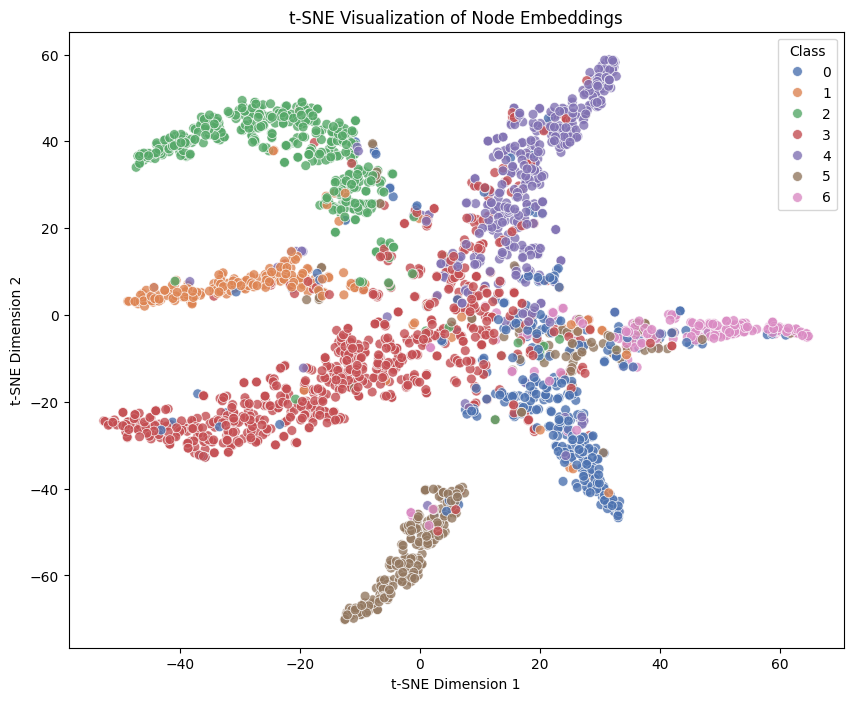

In [16]:
train_acc, val_acc, test_acc = evaluate_model(model, data, device)
print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

# Visualize Embeddings
visualize_embeddings(model, data, device)

## Hyperparameter Tuning

In [17]:
param_grid = {
    'lr': [0.01, 0.005, 0.001],
    'hidden_dim': [8, 16, 32],
    'dropout': [0.5, 0.3, 0.1]
}
best_params = hyperparameter_tuning(num_classes, data, param_grid, epochs=200, device=device)

Testing Hyperparameters: LR=0.01, Hidden=8, Dropout=0.5
New Best Params: {'lr': 0.01, 'hidden_dim': 8, 'dropout': 0.5}, Val Acc: 0.7400
Testing Hyperparameters: LR=0.01, Hidden=8, Dropout=0.3
New Best Params: {'lr': 0.01, 'hidden_dim': 8, 'dropout': 0.3}, Val Acc: 0.7820
Testing Hyperparameters: LR=0.01, Hidden=8, Dropout=0.1
Testing Hyperparameters: LR=0.01, Hidden=16, Dropout=0.5
Testing Hyperparameters: LR=0.01, Hidden=16, Dropout=0.3
Testing Hyperparameters: LR=0.01, Hidden=16, Dropout=0.1
Testing Hyperparameters: LR=0.01, Hidden=32, Dropout=0.5
Testing Hyperparameters: LR=0.01, Hidden=32, Dropout=0.3
Testing Hyperparameters: LR=0.01, Hidden=32, Dropout=0.1
Testing Hyperparameters: LR=0.005, Hidden=8, Dropout=0.5
New Best Params: {'lr': 0.005, 'hidden_dim': 8, 'dropout': 0.5}, Val Acc: 0.7840
Testing Hyperparameters: LR=0.005, Hidden=8, Dropout=0.3
Testing Hyperparameters: LR=0.005, Hidden=8, Dropout=0.1
Testing Hyperparameters: LR=0.005, Hidden=16, Dropout=0.5
Testing Hyperparamet

## Initialize Model, Optimizer, and Loss Function

In [18]:
tuned_model = GCNModel(
    input_dim=dataset.num_node_features,
    hidden_dim=32,
    output_dim=dataset.num_classes,
    dropout=0.5
)
tuned_optimizer = torch.optim.Adam(tuned_model.parameters(), lr=0.005, weight_decay=5e-4)
tuned_criterion = torch.nn.CrossEntropyLoss()

# Train the Model
train_model(tuned_model, data, tuned_optimizer, tuned_criterion, epochs=200, device=device)


Epoch 000 | Loss: 1.9554 | Train Acc: 0.5786 | Val Acc: 0.3820 | Test Acc: 0.3480
Epoch 010 | Loss: 0.9851 | Train Acc: 0.9643 | Val Acc: 0.7080 | Test Acc: 0.7260
Epoch 020 | Loss: 0.3553 | Train Acc: 0.9857 | Val Acc: 0.7800 | Test Acc: 0.7960
Epoch 030 | Loss: 0.1282 | Train Acc: 1.0000 | Val Acc: 0.7780 | Test Acc: 0.8010
Epoch 040 | Loss: 0.0721 | Train Acc: 1.0000 | Val Acc: 0.7720 | Test Acc: 0.7950
Epoch 050 | Loss: 0.0425 | Train Acc: 1.0000 | Val Acc: 0.7700 | Test Acc: 0.7930
Epoch 060 | Loss: 0.0396 | Train Acc: 1.0000 | Val Acc: 0.7640 | Test Acc: 0.7900
Epoch 070 | Loss: 0.0314 | Train Acc: 1.0000 | Val Acc: 0.7620 | Test Acc: 0.7900
Epoch 080 | Loss: 0.0288 | Train Acc: 1.0000 | Val Acc: 0.7660 | Test Acc: 0.7940
Epoch 090 | Loss: 0.0313 | Train Acc: 1.0000 | Val Acc: 0.7660 | Test Acc: 0.7910
Epoch 100 | Loss: 0.0290 | Train Acc: 1.0000 | Val Acc: 0.7700 | Test Acc: 0.7950
Epoch 110 | Loss: 0.0247 | Train Acc: 1.0000 | Val Acc: 0.7660 | Test Acc: 0.7910
Epoch 120 | Loss

## Evaluate the Tuned Model

Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.8050


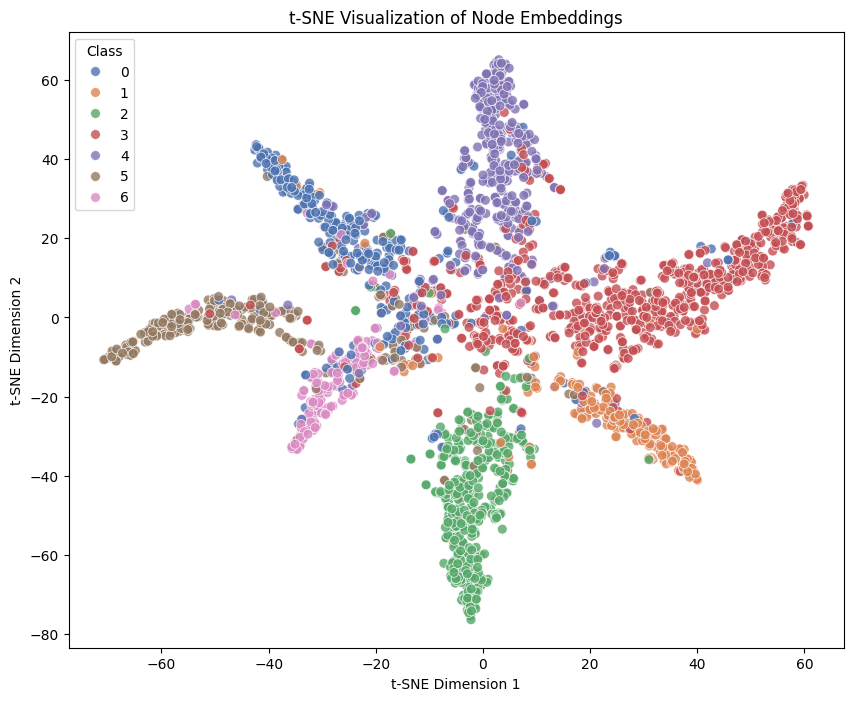

In [19]:
tuned_train_acc, tuned_val_acc, tuned_test_acc = evaluate_model(tuned_model, data, device)
print(f"Train Acc: {tuned_train_acc:.4f}, Val Acc: {tuned_val_acc:.4f}, Test Acc: {tuned_test_acc:.4f}")

# Visualize Embeddings
visualize_embeddings(tuned_model, data, device)

In [20]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def calculate_metrics(model, data, device):
    """
    Calculate accuracy, precision, recall, and F1-score for the GCN model.

    Args:
        model (torch.nn.Module): The trained GCN model.
        data (torch_geometric.data.Data): The graph data containing features and labels.
        device (torch.device): The device to perform computation (CPU or GPU).

    Returns:
        tuple: Accuracy, precision, recall, F1-score, and confusion matrix.
    """
    model.eval()  # Set model to evaluation mode
    data = data.to(device)  # Move data to the specified device
    
    with torch.no_grad():
        # Perform a forward pass to get logits (predicted probabilities)
        logits = model(data.x, data.edge_index)
        # Take the class with the highest probability as the prediction
        pred = logits.argmax(dim=1)

    # Extract true labels and predictions for metric calculations
    true_labels = data.y.cpu().numpy()
    pred_labels = pred.cpu().numpy()

    # Calculate accuracy
    accuracy = (pred_labels == true_labels).sum() / len(true_labels)

    # Calculate precision, recall, and F1-score (weighted for class imbalance)
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    f1 = f1_score(true_labels, pred_labels, average='weighted')

    # Generate the confusion matrix
    conf_matrix = confusion_matrix(true_labels, pred_labels)

    return accuracy, precision, recall, f1, conf_matrix


def plot_confusion_matrix(conf_matrix, class_names):
    """
    Plot the confusion matrix as a heatmap.

    Args:
        conf_matrix (numpy.ndarray): The confusion matrix.
        class_names (list): The list of class names for labeling the heatmap.
    """
    plt.figure(figsize=(10, 8))
    # Use seaborn to create a heatmap with annotations
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


In [21]:
def plot_metrics_bar_chart(metrics):
    """
    Plot a bar chart to visualize accuracy, precision, recall, and F1-score.

    Args:
        metrics (dict): A dictionary containing the performance metrics.
    """
    plt.figure(figsize=(8, 6))
    metric_names = list(metrics.keys())
    metric_values = list(metrics.values())

    # Create a bar chart
    sns.barplot(x=metric_names, y=metric_values, palette='viridis')
    plt.title('Performance Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)  # Scores are typically between 0 and 1
    plt.xlabel('Metrics')
    for i, value in enumerate(metric_values):
        plt.text(i, value + 0.02, f"{value:.2f}", ha='center')
    plt.show()

## Evaluate the model

Accuracy: 0.8098
Precision: 0.8233
Recall: 0.8098
F1-Score: 0.8108


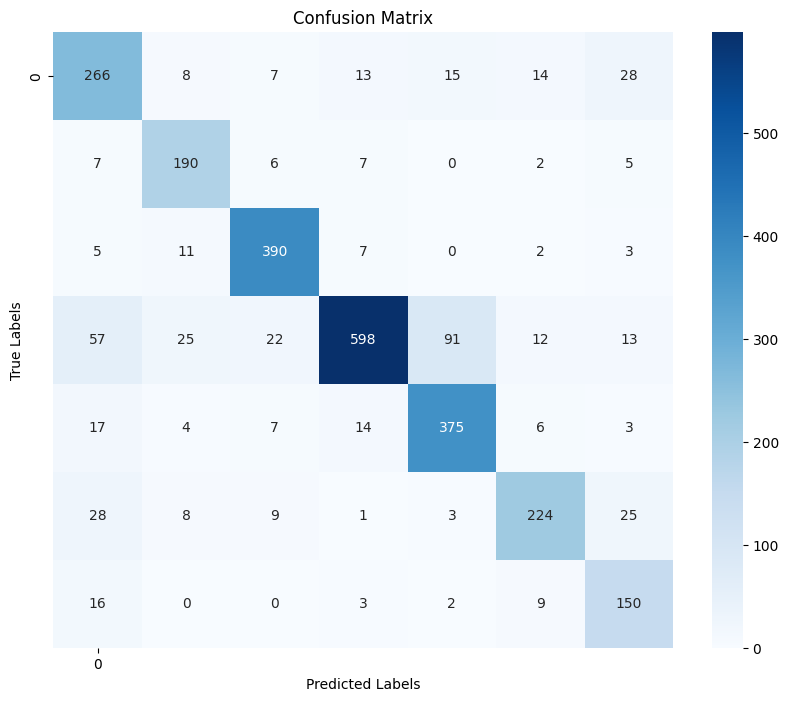

In [22]:
accuracy, precision, recall, f1, conf_matrix = calculate_metrics(tuned_model, data, device)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, class_names=num_classes)

## Visualize metrics as a bar chart

/var/folders/n8/zv0wkckj2yj0wtbp49j0czh40000gp/T/ipykernel_63104/580316433.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_names, y=metric_values, palette='viridis')


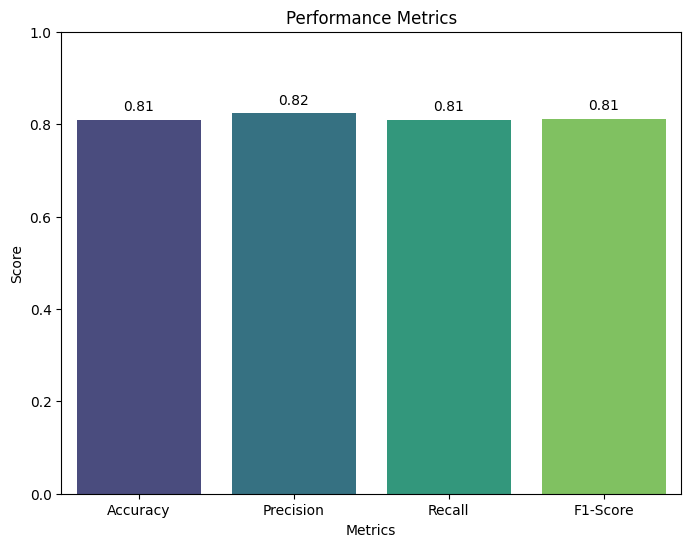

In [23]:
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}
plot_metrics_bar_chart(metrics)